### 0.0. Dependencies and Data

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

In [3]:
retail_areas = pd.read_csv("retail_areas_final.csv")

In [4]:
print(retail_areas.dtypes)

date                                                       object
id                                                          int64
events                                                      int64
weekend                                                      bool
season                                                     object
holiday                                                      bool
Local_Footprint_Centre_ID                                  object
Residential Population (Weighted Catchment)                 int64
Retail Footprint Score                                    float64
Base Score                                                float64
Tourism Score                                             float64
Convenience_Score                                         float64
Retail_Footprint_Comparison_Retailer_Score                float64
Leisure_Footprint_Score                                   float64
Auto_Score                                                float64
Local Foot

### 1.1. Model Prep

#### 1.1.1. Check for linear relationships

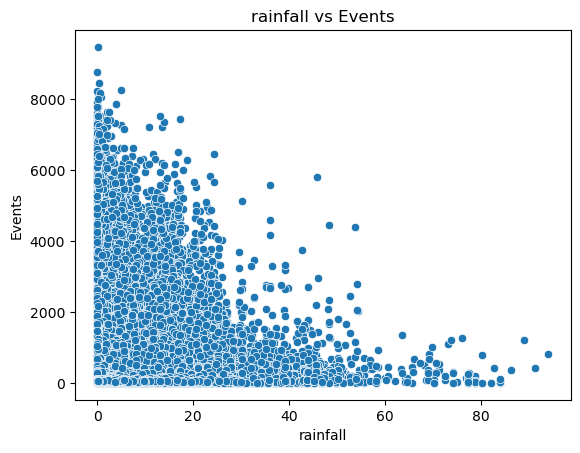

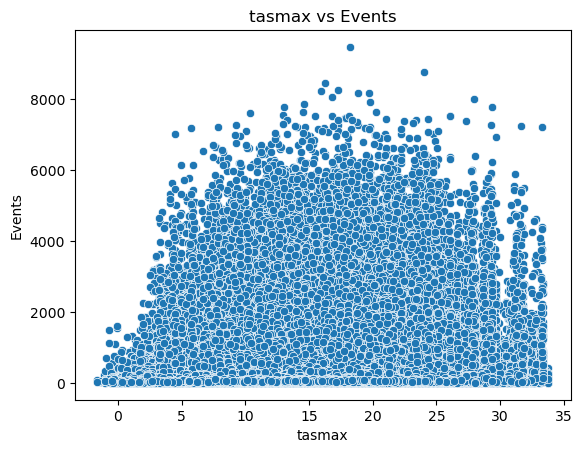

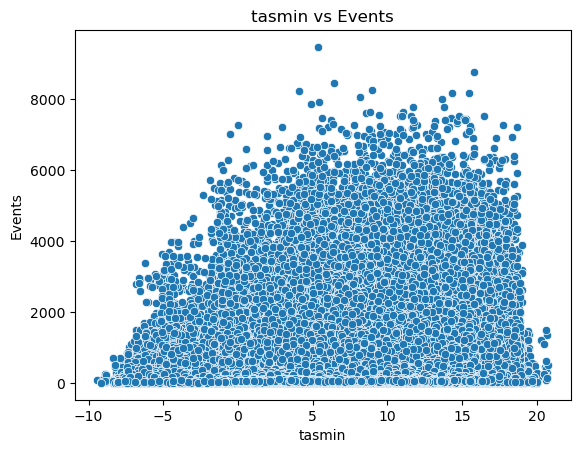

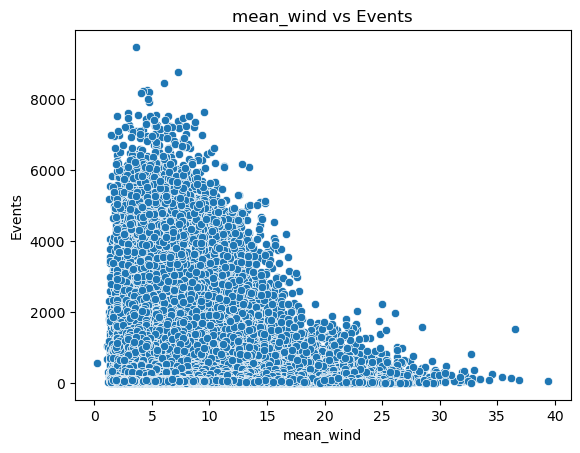

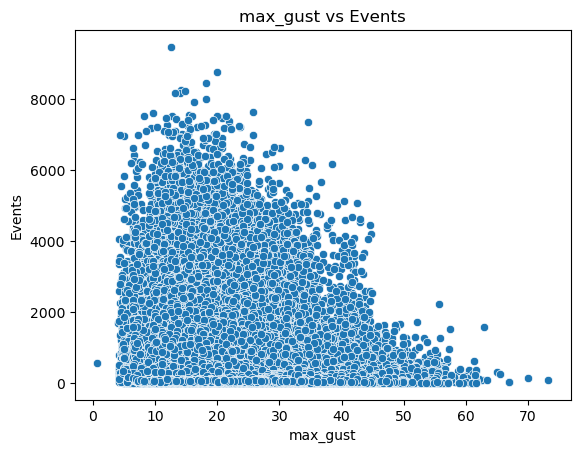

In [74]:
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']

for var in weather_vars:
    sns.scatterplot(x=var, y='events', data=retail_areas)
    plt.title(f'{var} vs Events')
    plt.xlabel(var)
    plt.ylabel('Events')
    plt.show()

#### 1.1.2. Var encoding

In [6]:
# copy to avoid modifying original
df_model = retail_areas.copy()

# binary encode 'coastal'
df_model['coastal'] = df_model['coastal'].map({'coastal': 1, 'inland': 0})

# one-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region', 'groupName']
df_model = pd.get_dummies(df_model, columns=cat_vars, drop_first=True)

### 1.2. General Model

#### 1.2.1. Most basic without weather

In [57]:
# define target and features
target = 'events'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'weekend',
    'holiday',
]

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

# drop NaNs
df_model = df_model.dropna(subset=[target] + features)

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [58]:
print(df_model.groupby('date')['id'].nunique())

date
2024-01-15    1408
2024-01-16    1410
2024-01-17    1408
2024-01-18    1412
2024-01-19    1417
              ... 
2024-11-20    1419
2024-11-25    1422
2024-11-26    1417
2024-11-27    1421
2024-12-02    1417
Name: id, Length: 255, dtype: int64


In [59]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical. The index indicates which rows from the original data.

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(289303, 3)
(289303,)
(72326, 3)
(72326,)
True
True


Hyperparameters:

In [60]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................max_depth=10, min_samples_split=2; total time=   9.3s
[CV] END ..................max_depth=10, min_samples_split=6; total time=   7.5s
[CV] END ..................max_depth=10, min_samples_split=2; total time=   9.1s
[CV] END ..................max_depth=10, min_samples_split=4; total time=   9.3s
[CV] END ..................max_depth=10, min_samples_split=2; total time=   9.4s
[CV] END ..................max_depth=10, min_samples_split=6; total time=   9.2s
[CV] END ..................max_depth=10, min_samples_split=4; total time=   9.6s
[CV] END ..................max_depth=10, min_samples_split=4; total time=   9.6s
[CV] END ..................max_depth=10, min_samples_split=6; total time=   9.3s
[CV] END ..................max_depth=10, min_samples_split=4; total time=   9.5s
[CV] END ..................max_depth=10, min_samples_split=2; total time=   9.7s
[CV] END ..................max_depth=10, min_sa

Build random forest:

In [71]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [72]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.6565036567885066
R² on the testing data:
0.6482362536357391


In [69]:
rf_final = RandomForestRegressor(**clf.best_params_, 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,40
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [70]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.6565011749652998
R² on the testing data:
0.6482494907833914


In [65]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
368.40483544774713
RMSE on the testing data:
375.9692655342253


                                             Importance
Feature                                                
Residential Population (Weighted Catchment)    1.385544
weekend                                        0.004643
holiday                                        0.001364


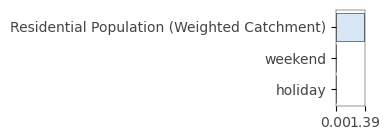

In [66]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### 1.2.2. Add score variables

Train/test:

In [8]:
# define target and features
target = 'events'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
]

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

# drop NaNs
df_model = df_model.dropna(subset=[target] + features)

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [56]:
print(df_model.groupby('date')['id'].nunique())

date
2024-01-15    1408
2024-01-16    1410
2024-01-17    1408
2024-01-18    1412
2024-01-19    1417
              ... 
2024-11-20    1419
2024-11-25    1422
2024-11-26    1417
2024-11-27    1421
2024-12-02    1417
Name: id, Length: 255, dtype: int64


In [9]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical. The index indicates which rows from the original data.

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(418176, 6)
(418176,)
(104544, 6)
(104544,)
True
True


Hyperparameters:

In [10]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................max_depth=10, min_samples_split=2; total time=  27.4s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  27.4s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  28.8s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  28.7s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  29.7s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  30.1s
[CV] END .................max_depth=10, min_samples_split=10; total time=  30.2s
[CV] END ..................max_depth=20, min_samples_split=4; total time=  30.3s
[CV] END ..................max_depth=30, min_samples_split=6; total time=  30.3s
[CV] END ..................max_depth=30, min_samples_split=8; total time=  30.4s
[CV] END ..................max_depth=30, min_samples_split=2; total time=  30.6s
[CV] END ..................max_depth=30, min_sa

Build random forest:

In [11]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [12]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9085290308941814
R² on the testing data:
0.9041079633498201


In [13]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,30
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [14]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9085069961305065
R² on the testing data:
0.90420094803526


In [15]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
188.92144028341755
RMSE on the testing data:
193.55289837656383


                                             Importance
Feature                                                
Leisure_Footprint_Score                        1.185719
Tourism Score                                  0.451980
Retail Footprint Score                         0.286012
Residential Population (Weighted Catchment)    0.221201
weekend                                        0.014573
holiday                                        0.005434


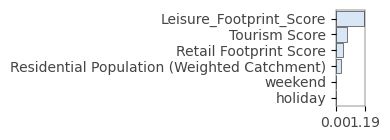

In [24]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### 1.2.3. Add categoricals

Train/test:

In [25]:
# define target and features
target = 'events'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns 
     if col.startswith('season_') or col.startswith('groupName_')]

# split the data into training and testing sets
random_state_split = 100  # for reproducibility

# drop NaNs
df_model = df_model.dropna(subset=[target] + features)

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [26]:
print(features)

['Residential Population (Weighted Catchment)', 'Tourism Score', 'Retail Footprint Score', 'Leisure_Footprint_Score', 'weekend', 'holiday', 'season_Spring', 'season_Summer', 'season_Winter', 'groupName_Indie high streets', 'groupName_Large regional retail and leisure destinations', 'groupName_Local urban convenience centres', 'groupName_Mass and value high streets', 'groupName_Primary shopping centres and premium destinations', 'groupName_Secondary retail parks and shopping centres', 'groupName_Sub-regional retail and leisure destinations']


In [27]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(418176, 16)
(418176,)
(104544, 16)
(104544,)
True
True


Hyperparameters:

In [28]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................max_depth=10, min_samples_split=2; total time=  55.5s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  56.0s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  56.0s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  59.5s
[CV] END .................max_depth=10, min_samples_split=10; total time=  56.5s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  57.3s
[CV] END .................max_depth=10, min_samples_split=10; total time=  57.4s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  58.3s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  58.5s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  58.5s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  59.1s
[CV] END ..................max_depth=10, min_sa

Build random forest:

In [29]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [30]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.937311245760991
R² on the testing data:
0.9305889055072157


In [31]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,30
,min_samples_split,6
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [32]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9372260532518457
R² on the testing data:
0.9307798770000343


In [33]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
156.48655217032308
RMSE on the testing data:
164.52627186415876


                                                    Importance
Feature                                                       
Leisure_Footprint_Score                               1.406228
Tourism Score                                         0.436695
Retail Footprint Score                                0.289564
groupName_Indie high streets                          0.232692
Residential Population (Weighted Catchment)           0.164103
groupName_Local urban convenience centres             0.047019
season_Winter                                         0.039177
season_Spring                                         0.034511
weekend                                               0.022508
groupName_Secondary retail parks and shopping c...    0.016166
season_Summer                                         0.005226
holiday                                               0.002422
groupName_Large regional retail and leisure des...    0.001671
groupName_Mass and value high streets                 0

/workspace/.conda/lib/python3.11/site-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


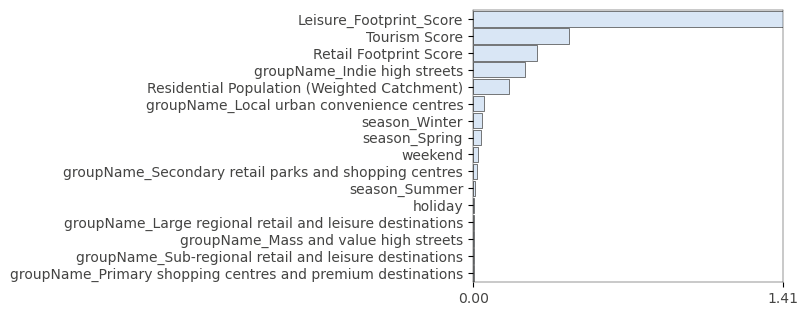

In [34]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### 1.2.4. With weather

Train/test:

In [35]:
# define target and features
target = 'events'

# features list
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + weather_vars  + [col for col in df_model.columns 
                     if col.startswith('season_') or col.startswith('groupName_')] 

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

# drop NaNs
df_model = df_model.dropna(subset=[target] + features)

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [36]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(289303, 21)
(289303,)
(72326, 21)
(72326,)
True
True


Hyperparameters:

In [37]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 2.0min
[CV] END .................max_depth=10, min_samples_split=10; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 2.0min
[CV] END .................max_depth=10, min_samples_split=10; total time= 2.0min
[CV] END ..................max_depth=10, min_sa

Build random forest:

In [38]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [39]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9908930224879019
R² on the testing data:
0.9360937384607905


In [40]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [41]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9714194435466766
R² on the testing data:
0.9377986303177244


In [42]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
106.26690547030053
RMSE on the testing data:
158.10112148035526


                                                    Importance
Feature                                                       
Leisure_Footprint_Score                               1.359512
Tourism Score                                         0.464085
groupName_Indie high streets                          0.280403
Retail Footprint Score                                0.257832
Residential Population (Weighted Catchment)           0.143669
groupName_Local urban convenience centres             0.069759
season_Winter                                         0.035265
season_Spring                                         0.022191
weekend                                               0.021959
groupName_Secondary retail parks and shopping c...    0.008737
tasmax                                                0.005488
groupName_Primary shopping centres and premium ...    0.003662
season_Summer                                         0.003643
tasmin                                                0

/workspace/.conda/lib/python3.11/site-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


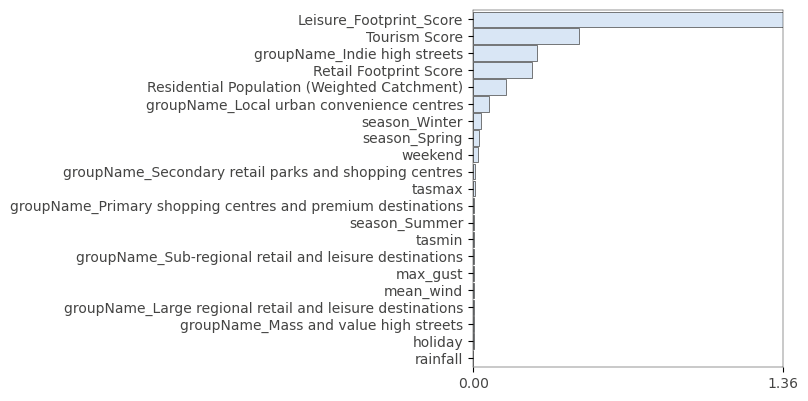

In [43]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

### 1.3. Model w/ retail type

In [44]:
# copy to avoid modifying original
df_model = retail_areas.copy()

# binary encode 'coastal'
df_model['coastal'] = df_model['coastal'].map({'coastal': 1, 'inland': 0})

# One-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region']
            #'supergroupName', 'groupName']
df_model = pd.get_dummies(df_model, columns=cat_vars, drop_first=True)

#### 1.3.1. Without weather

Model:

In [45]:
group_col = 'groupName'
randomState_dt = 10000

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
    'Tourism Score',
] + [col for col in df_model.columns if col.startswith('season_')]

# drop NaNs
df_model = df_model.dropna(subset=[target] + features)

for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # skip small groups

    # train-test split per group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    model = RandomForestRegressor(random_state=randomState_dt).fit(train_x, train_y)
    
    # scores
    r2_train = model.score(train_x, train_y)
    r2_test = model.score(test_x, test_y)

    importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    print(f"\nGroup: {name}")
    print(f"R² (train): {r2_train:.3f} | R² (test): {r2_test:.3f}")
    print("Feature Importances:")
    print(importances.round(3))



Group: District urban service centres
R² (train): 0.957 | R² (test): 0.949
Feature Importances:
Leisure_Footprint_Score                        0.575
Retail Footprint Score                         0.204
Tourism Score                                  0.141
Residential Population (Weighted Catchment)    0.043
season_Winter                                  0.014
season_Spring                                  0.010
weekend                                        0.007
season_Summer                                  0.003
holiday                                        0.003
dtype: float64

Group: Indie high streets
R² (train): 0.861 | R² (test): 0.843
Feature Importances:
Leisure_Footprint_Score                        0.475
Tourism Score                                  0.269
Retail Footprint Score                         0.121
Residential Population (Weighted Catchment)    0.061
season_Winter                                  0.026
season_Spring                                  0.019
weekend 

Add calibration:

In [46]:
# loop over groups
for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # Skip small groups

    # split train/test within each group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    # hyperparameter tuning for this group
    rf = RandomForestRegressor(random_state=randomState_dt)
    hyperparameters = {'max_depth': [10, 20, 30, 40, 50],
                       'min_samples_split': [2, 4, 6, 8, 10]}
    
    clf = GridSearchCV(rf, hyperparameters, cv=5, n_jobs=-1)
    clf.fit(train_x, train_y)

    print(f"\nGroup: {name}")
    print("Best parameters:", clf.best_params_)
    print("Best CV R² score:", round(clf.best_score_, 3))

    # fit tuned model
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    ).fit(train_x, train_y)

    # evaluate
    r2_train = model.score(train_x, train_y)
    r2_test = model.score(test_x, test_y)
    importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    print(f"R² (train): {r2_train:.3f} | R² (test): {r2_test:.3f}")
    print("Feature Importances:")
    print(importances.round(3))




Group: District urban service centres
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Best CV R² score: 0.953
R² (train): 0.957 | R² (test): 0.949
Feature Importances:
Leisure_Footprint_Score                        0.575
Retail Footprint Score                         0.205
Tourism Score                                  0.141
Residential Population (Weighted Catchment)    0.042
season_Winter                                  0.014
season_Spring                                  0.010
weekend                                        0.007
season_Summer                                  0.003
holiday                                        0.003
dtype: float64

Group: Indie high streets
Best parameters: {'max_depth': 20, 'min_samples_split': 4}
Best CV R² score: 0.849
R² (train): 0.861 | R² (test): 0.843
Feature Importances:
Leisure_Footprint_Score                        0.476
Tourism Score                                  0.266
Retail Footprint Score                         0.123


#### 1.3.2. With weather

In [47]:
group_col = 'groupName'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
    'Tourism Score',
] + weather_vars + [col for col in df_model.columns if 
                    col.startswith('season_')]
 
# drop NaNs
df_model = df_model.dropna(subset=[target] + features)

for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # skip small groups

    # train-test split per group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    model = RandomForestRegressor(random_state=randomState_dt).fit(train_x, train_y)
    
    # Scores
    r2_train = model.score(train_x, train_y)
    r2_test = model.score(test_x, test_y)

    importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    print(f"\nGroup: {name}")
    print(f"R² (train): {r2_train:.3f} | R² (test): {r2_test:.3f}")
    print("Feature Importances:")
    print(importances.round(3))


Group: District urban service centres
R² (train): 0.994 | R² (test): 0.957
Feature Importances:
Leisure_Footprint_Score                        0.557
Retail Footprint Score                         0.198
Tourism Score                                  0.134
Residential Population (Weighted Catchment)    0.040
season_Winter                                  0.012
tasmax                                         0.011
season_Spring                                  0.010
tasmin                                         0.009
rainfall                                       0.007
mean_wind                                      0.007
max_gust                                       0.007
weekend                                        0.006
season_Summer                                  0.001
holiday                                        0.001
dtype: float64

Group: Indie high streets
R² (train): 0.979 | R² (test): 0.847
Feature Importances:
Leisure_Footprint_Score                        0.430
Tourism 

Add calibration:

In [48]:
# loop over groups
for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # Skip small groups

    # split train/test within each group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    # hyperparameter tuning for this group
    rf = RandomForestRegressor(random_state=randomState_dt)
    hyperparameters = {'max_depth': [10, 20, 30, 40, 50],
                       'min_samples_split': [2, 4, 6, 8, 10]}
    
    clf = GridSearchCV(rf, hyperparameters, cv=5, n_jobs=1)
    clf.fit(train_x, train_y)

    print(f"\nGroup: {name}")
    print("Best parameters:", clf.best_params_)
    print("Best CV R² score:", round(clf.best_score_, 3))

    # fit tuned model
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    ).fit(train_x, train_y)

    # evaluate
    r2_train = model.score(train_x, train_y)
    r2_test = model.score(test_x, test_y)
    importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    print(f"R² (train): {r2_train:.3f} | R² (test): {r2_test:.3f}")
    print("Feature Importances:")
    print(importances.round(3))



Group: District urban service centres
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Best CV R² score: 0.956
R² (train): 0.984 | R² (test): 0.957
Feature Importances:
Leisure_Footprint_Score                        0.564
Retail Footprint Score                         0.200
Tourism Score                                  0.137
Residential Population (Weighted Catchment)    0.040
season_Winter                                  0.012
season_Spring                                  0.010
tasmax                                         0.009
tasmin                                         0.006
weekend                                        0.006
mean_wind                                      0.005
rainfall                                       0.005
max_gust                                       0.005
season_Summer                                  0.001
holiday                                        0.001
dtype: float64

Group: Indie high streets
Best parameters: {'max_depth': 20, 

In [52]:
print(df_model['holiday'].value_counts())

holiday
False    354564
True       7065
Name: count, dtype: int64


Partial dependence plots:

In [49]:
from sklearn.inspection import PartialDependenceDisplay

for name, group_data in df_model.groupby('groupName'):
    if len(group_data) < 30:
        continue  # Skip small groups

    X = group_data[weather_vars].copy()
    y = group_data['events']

    # Handle missing values (robustness)
    X = X.fillna(X.median())

    # Fit tuned model
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    ).fit(X, y)

    # Prepare layout
    n_features = len(weather_vars)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    ax = np.atleast_1d(ax).flatten()

    # Plot partial dependence
    PartialDependenceDisplay.from_estimator(
        model,
        X,
        features=weather_vars,
        ax=ax[:n_features]
    )

    for axis in ax[:n_features]:
        axis.set_ylim(0, 1500)  # Optional: adjust y-limits for interpretability

    plt.suptitle(f'Partial Dependence - {name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

NameError: name 'math' is not defined

### 1.4. Retail model per sparsity

- London
- Other urban
- Rural 
- Coastal

In [ ]:
#...

#### later

Leisure footprint?
rail/tube--- specifically for london?